## Import Library

In [309]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Data Loading

In [310]:
# Membaca data ratings
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('dataset/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

In [311]:
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [312]:
# Membaca data movies  
movies_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url']
genres = ['unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
          'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery',
          'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_cols.extend(genres)
movies = pd.read_csv('dataset/u.item', sep='|', names=movies_cols, encoding='latin-1')

In [313]:
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Data Understanding

In [314]:
# Jumlah data
print(f"Jumlah total rating: {len(ratings)}")
print(f"Jumlah pengguna unik: {ratings['user_id'].nunique()}")
print(f"Jumlah film unik: {ratings['item_id'].nunique()}")

Jumlah total rating: 100000
Jumlah pengguna unik: 943
Jumlah film unik: 1682


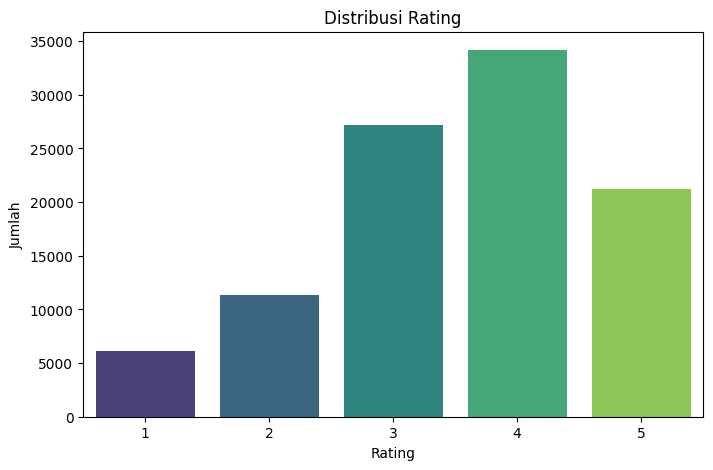

In [315]:
# Distribusi Rating
plt.figure(figsize=(8,5))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

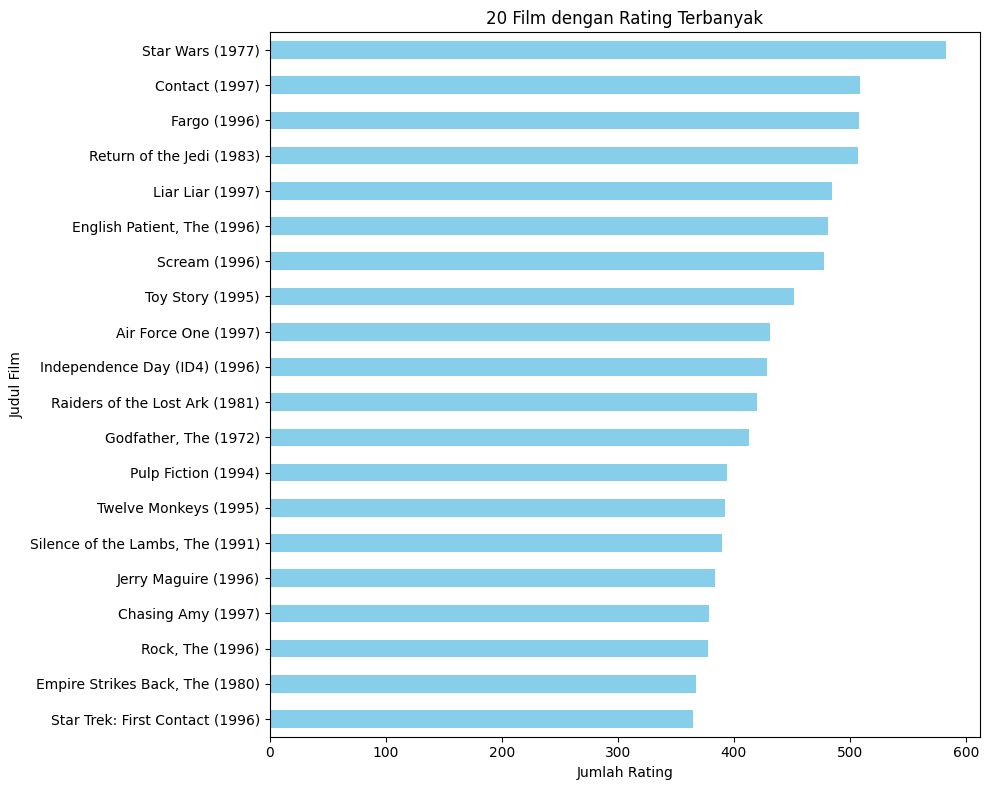

In [316]:
# 20 Film dengan Rating Terbanyak

# Gabungkan data ratings dan judul film
ratings_movies = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')

# Hitung jumlah rating per film
top_rated_movies = ratings_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

# Visualisasi
plt.figure(figsize=(10,8))
top_rated_movies.sort_values().plot(kind='barh', color='skyblue')
plt.title('20 Film dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Judul Film')
plt.tight_layout()
plt.show()

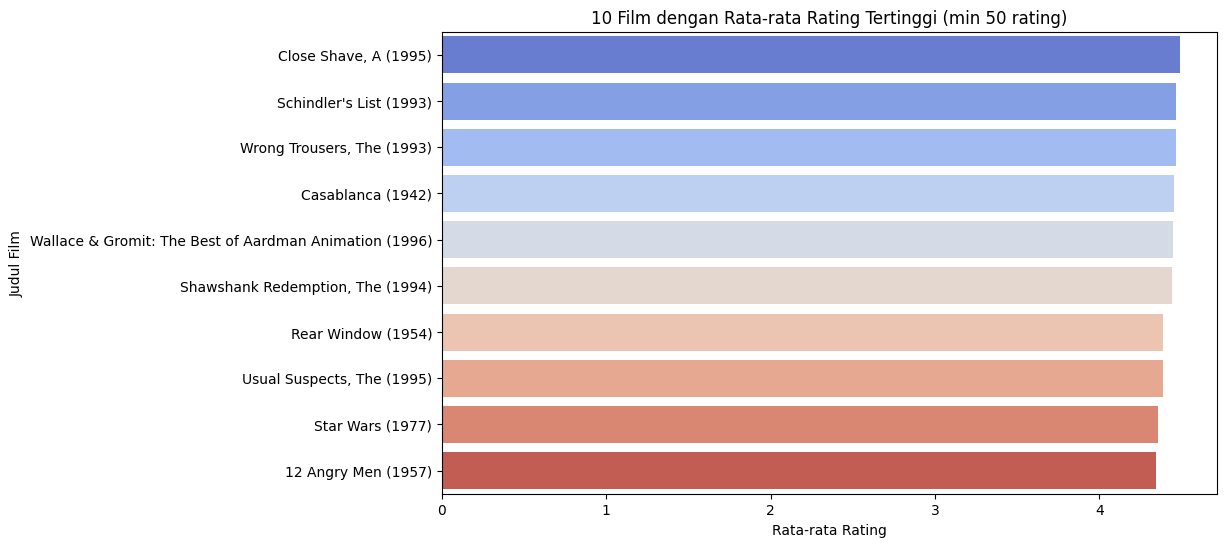

In [317]:
# Rata-rata Rating Tertinggi (Film dengan >=50 rating)

movie_stats = ratings_movies.groupby('title').agg({'rating': ['mean', 'count']})
movie_stats.columns = ['avg_rating', 'count_rating']
popular_movies = movie_stats[movie_stats['count_rating'] >= 50].sort_values(by='avg_rating', ascending=False).head(10)

# Visualisasi
plt.figure(figsize=(10,6))
sns.barplot(data=popular_movies.reset_index(), x='avg_rating', y='title', palette='coolwarm')
plt.title('10 Film dengan Rata-rata Rating Tertinggi (min 50 rating)')
plt.xlabel('Rata-rata Rating')
plt.ylabel('Judul Film')
plt.show()

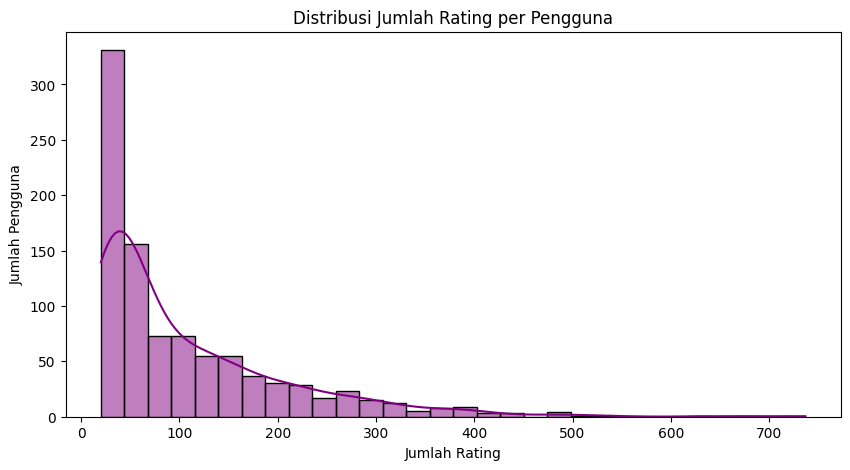

In [318]:
# Aktivitas Rating Pengguna
user_activity = ratings['user_id'].value_counts()

plt.figure(figsize=(10,5))
sns.histplot(user_activity, bins=30, kde=True, color='purple')
plt.title('Distribusi Jumlah Rating per Pengguna')
plt.xlabel('Jumlah Rating')
plt.ylabel('Jumlah Pengguna')
plt.show()

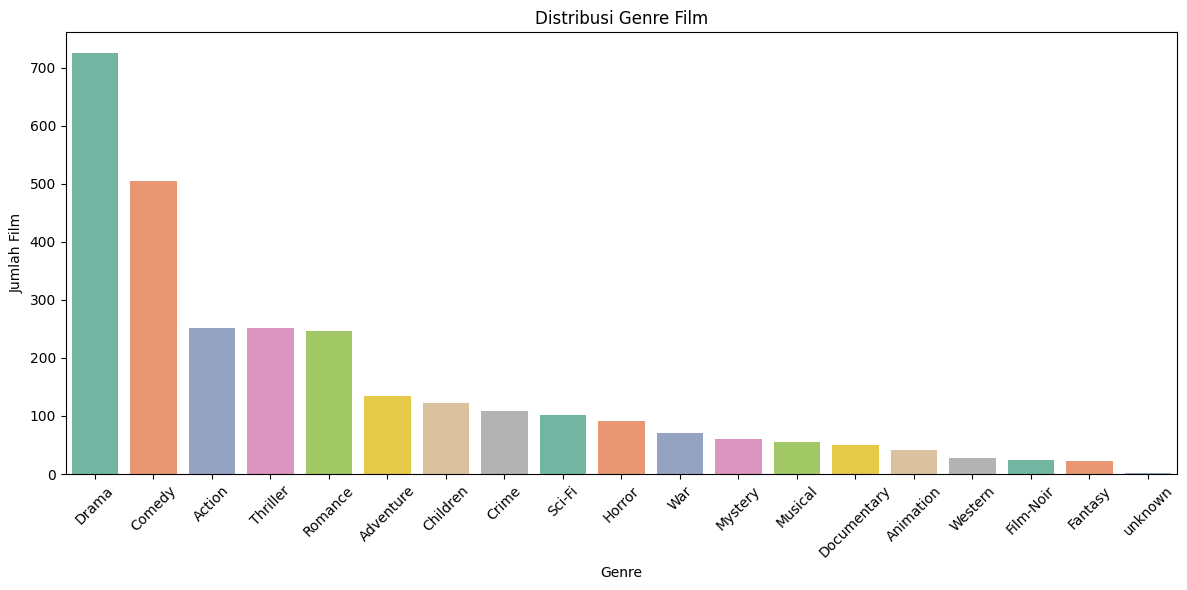

In [319]:
# Distribusi Genre Film

# Kombinasi genre
genre_cols = movies.columns[5:]  # 5 kolom pertama: id, title, release_date, etc
movies['genre_string'] = movies[genre_cols].apply(lambda x: '|'.join(genre_cols[x==1]), axis=1)

# Pisahkan genre untuk analisis
genre_explode = movies[['movie_id', 'genre_string']].copy()
genre_explode = genre_explode.assign(genre=genre_explode['genre_string'].str.split('|')).explode('genre')

# Visualisasi
plt.figure(figsize=(12,6))
sns.countplot(data=genre_explode, x='genre', order=genre_explode['genre'].value_counts().index, palette='Set2')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

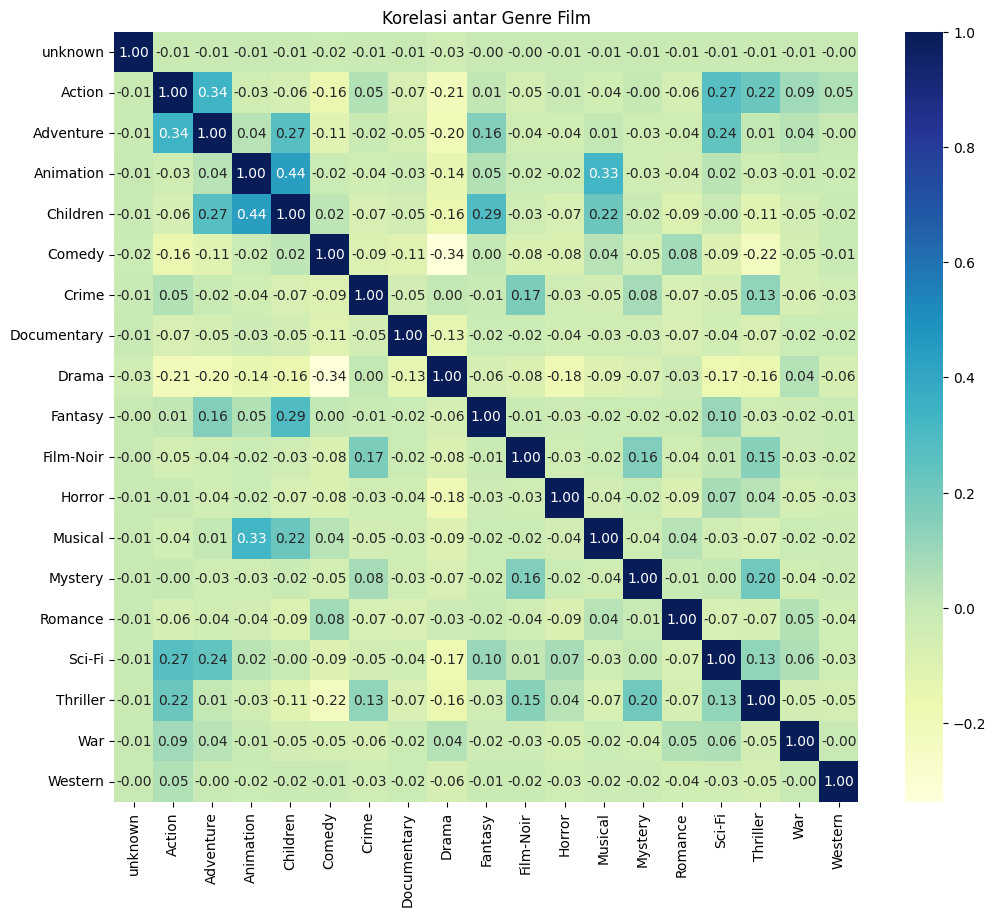

In [321]:
# Korelasi Rating antar Genre
genre_matrix = movies[genres].corr()

plt.figure(figsize=(12,10))
sns.heatmap(genre_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Korelasi antar Genre Film')
plt.show()

## Data Preparation

In [322]:
# Merge data untuk analisis lengkap
movie_ratings = pd.merge(ratings, movies[['movie_id', 'title'] + genre_columns], 
                        left_on='item_id', right_on='movie_id')

In [323]:
# Membuat genre string untuk content-based filtering
movies['genre_string'] = ''
for idx, row in movies.iterrows():
    active_genres = []
    for genre in genre_columns:
        if row[genre] == 1:
            active_genres.append(genre)
    movies.at[idx, 'genre_string'] = ' '.join(active_genres)

In [324]:
# Statistik film dengan genre
movies_with_genres = movies[movies['genre_string'] != ''].copy()
print(f"Film dengan genre: {len(movies_with_genres):,}")
print(f"Film tanpa genre: {len(movies) - len(movies_with_genres):,}")

Film dengan genre: 1,680
Film tanpa genre: 2


In [325]:
# Split data untuk evaluasi
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)
print(f"Training data: {len(train_data):,}")
print(f"Testing data: {len(test_data):,}")

Training data: 80,000
Testing data: 20,000


In [326]:
# Membuat user-item matrix untuk data pengujian
test_user_item_matrix = test_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(f"Test User-item matrix shape: {test_user_item_matrix.shape}")

Test User-item matrix shape: (940, 1411)


In [327]:
# Membuat user-item matrix untuk collaborative filtering
train_user_item_matrix = train_data.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
print(f"Train User-item matrix shape: {train_user_item_matrix.shape}")

Train User-item matrix shape: (943, 1653)


In [328]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating').fillna(0)

# Tambahan informasi sparsity dan rata-rata rating per pengguna
print(f"Sparsity matrix user-item: {(user_item_matrix == 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100:.1f}%")
ratings_per_user = ratings.groupby('user_id')['rating'].count()
print(f"Rata-rata rating per pengguna: {ratings_per_user.mean():.0f}\nVariasi rating terendah per user: {ratings_per_user.min()}\nVariasi rating tertinggi per user: {ratings_per_user.max()}")

Sparsity matrix user-item: 93.7%
Rata-rata rating per pengguna: 106
Variasi rating terendah per user: 20
Variasi rating tertinggi per user: 737


## Modeling

Content-Based Filtering

In [329]:
# TF-IDF Vectorization untuk genre
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_with_genres['genre_string'])

In [330]:
# Menghitung cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [331]:
# Membuat mapping judul ke index
indices = pd.Series(movies_with_genres.index, index=movies_with_genres['title']).drop_duplicates()

In [332]:
# Fungsi rekomendasi content-based
def get_content_recommendations(title, cosine_sim=cosine_sim, df=movies_with_genres, top_n=10):
    """
    Memberikan rekomendasi berdasarkan content similarity
    """
    try:
        # Pastikan judul ada di index
        if title not in indices:
            return f"Film '{title}' tidak ditemukan dalam dataset."

        # Ambil index film
        idx = indices[title]

        # Ambil vektor similarity untuk film tersebut (pastikan 1D array)
        sim_scores = list(enumerate(cosine_sim[idx]))

        # Urutkan berdasarkan similarity score (descending)
        sim_scores = sorted(sim_scores, key=lambda x: float(x[1]), reverse=True)

        # Ambil top N (kecuali diri sendiri di posisi pertama)
        sim_scores = sim_scores[1:top_n + 1]

        # Ambil index film yang disarankan
        movie_indices = [i[0] for i in sim_scores]

        # Ambil data film
        recommendations = df.iloc[movie_indices][['title', 'genre_string']].copy()
        recommendations['similarity_score'] = [float(score[1]) for score in sim_scores]

        return recommendations

    except Exception as e:
        return f"Terjadi error saat mencari rekomendasi untuk '{title}': {str(e)}"

In [333]:
# Test rekomendasi content-based
test_movie = "Toy Story (1995)"
print(f"\nRekomendasi Content-Based untuk '{test_movie}':")
content_recs = get_content_recommendations(test_movie, top_n=5)
if isinstance(content_recs, pd.DataFrame):
    for i, (_, row) in enumerate(content_recs.iterrows(), 1):
        print(f"{i}. {row['title']}")
        print(f"   Genre: {row['genre_string']}")
        print(f"   Similarity: {row['similarity_score']:.3f}")
        print()
else:
    print(content_recs)


Rekomendasi Content-Based untuk 'Toy Story (1995)':
1. Aladdin and the King of Thieves (1996)
   Genre: Animation Children Comedy
   Similarity: 1.000

2. Aristocats, The (1970)
   Genre: Animation Children
   Similarity: 0.937

3. Pinocchio (1940)
   Genre: Animation Children
   Similarity: 0.937

4. Sword in the Stone, The (1963)
   Genre: Animation Children
   Similarity: 0.937

5. Fox and the Hound, The (1981)
   Genre: Animation Children
   Similarity: 0.937



Collaborative Filtering

In [334]:
# Menggunakan SVD untuk matrix factorization
svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(user_item_matrix)
item_factors = svd.components_

In [335]:
# Rekonstruksi matrix
predicted_ratings = np.dot(user_factors, item_factors)
predicted_ratings_df = pd.DataFrame(predicted_ratings, 
                                  index=user_item_matrix.index, 
                                  columns=user_item_matrix.columns)

In [336]:
# Fungsi rekomendasi collaborative filtering
def get_collaborative_recommendations(user_id, predicted_ratings_df=predicted_ratings_df,
                                    train_user_item_matrix=train_user_item_matrix,
                                    movies_df=movies, top_n=10):
    
    if user_id not in predicted_ratings_df.index:
        return f"User ID {user_id} tidak ditemukan dalam model training."

    user_predictions = predicted_ratings_df.loc[user_id]

    # Ambil film yang belum dirating OLEH USER DI DATA TRAINING
    all_movie_ids = movies_df['movie_id'].unique()
    rated_movies_in_train = train_user_item_matrix.loc[user_id][train_user_item_matrix.loc[user_id] > 0].index.tolist()
    unrated_movies_ids = [mid for mid in all_movie_ids if mid not in rated_movies_in_train]

    # Filter prediksi untuk film yang belum dirating
    recommendations_for_unrated = user_predictions.reindex(unrated_movies_ids, fill_value=0)

    # Sort berdasarkan predicted rating
    recommendations_for_unrated = recommendations_for_unrated.sort_values(ascending=False).head(top_n)

    # Merge dengan informasi film
    rec_with_titles = []
    for movie_id, pred_rating in recommendations_for_unrated.items():
        movie_info = movies_df[movies_df['movie_id'] == movie_id]
        if not movie_info.empty:
            rec_with_titles.append({
                'movie_id': movie_id,
                'title': movie_info.iloc[0]['title'],
                'predicted_rating': pred_rating
            })

    return pd.DataFrame(rec_with_titles)

In [337]:
# Test rekomendasi collaborative filtering
test_user = 1
print(f"\nRekomendasi Collaborative Filtering untuk User {test_user}:")
collab_recs = get_collaborative_recommendations(test_user, top_n=5)
if isinstance(collab_recs, pd.DataFrame):
    for i, (_, row) in enumerate(collab_recs.iterrows(), 1):
        print(f"{i}. {row['title']}")
        print(f"   Predicted Rating: {row['predicted_rating']:.2f}")
        print()
else:
    print(collab_recs)


Rekomendasi Collaborative Filtering untuk User 1:
1. Fargo (1996)
   Predicted Rating: 6.40

2. Toy Story (1995)
   Predicted Rating: 5.11

3. Blues Brothers, The (1980)
   Predicted Rating: 4.63

4. Fish Called Wanda, A (1988)
   Predicted Rating: 4.56

5. Reservoir Dogs (1992)
   Predicted Rating: 4.39



## Evaluation

In [338]:
# Evaluasi Content-Based FilterinG
def evaluate_content_based(sample_titles, top_n=10):
    similarity_scores = []

    for title in sample_titles:
        recs = get_content_recommendations(title, top_n=top_n)
        if isinstance(recs, pd.DataFrame):
            similarity_scores.extend(recs['similarity_score'].values)

    if similarity_scores:
        mean_score = np.mean(similarity_scores)
        coverage = (len(similarity_scores) / (len(sample_titles) * top_n)) * 100
        return round(mean_score, 4), round(coverage, 1)
    else:
        return None, 0.0

In [339]:
# Evaluasi Collaborative Filtering - RMSE & MAE
def evaluate_collaborative_rmse(test_user_item_matrix, predicted_ratings_df):
    actuals, predictions = [], []

    for user in test_user_item_matrix.index:
        for item in test_user_item_matrix.columns:
            actual_rating = test_user_item_matrix.loc[user, item]
            if actual_rating > 0:
                actuals.append(actual_rating)
                predictions.append(predicted_ratings_df.loc[user, item])

    if actuals:
        rmse = sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        return round(rmse, 4), round(mae, 4)
    else:
        return None, None

In [340]:
# Evaluasi Collaborative Filtering - Precision@K
def precision_at_k(user_id, predicted_ratings_df, test_user_item_matrix, k=10, threshold=4.0):
    if user_id not in predicted_ratings_df.index:
        return None

    user_preds = predicted_ratings_df.loc[user_id]
    user_actuals = test_user_item_matrix.loc[user_id]

    relevant_items = user_actuals[user_actuals >= threshold].index.tolist()
    test_items = user_actuals[user_actuals > 0].index.tolist()

    if not test_items:
        return None

    top_k_items = user_preds[test_items].sort_values(ascending=False).head(k).index.tolist()
    num_relevant = len(set(top_k_items) & set(relevant_items))

    return num_relevant / k

def evaluate_precision_at_k(predicted_ratings_df, test_user_item_matrix, k=5, threshold=4.0):
    precisions = []

    for user_id in test_user_item_matrix.index:
        p_at_k = precision_at_k(user_id, predicted_ratings_df, test_user_item_matrix, k=k, threshold=threshold)
        if p_at_k is not None:
            precisions.append(p_at_k)

    return round(np.mean(precisions), 4) if precisions else None

In [341]:
sample_movies = movies_with_genres['title'].sample(10, random_state=42).tolist()

# Content-Based
content_mean_score, coverage_content = evaluate_content_based(sample_movies, top_n=5)

# Collaborative Filtering
rmse_score, mae_score = evaluate_collaborative_rmse(test_user_item_matrix, predicted_ratings_df)
avg_precision = evaluate_precision_at_k(predicted_ratings_df, test_user_item_matrix, k=5, threshold=4.0)

print("\nRingkasan Performa:")
print(f"- RMSE Collaborative       : {rmse_score:.3f}" if rmse_score else "- RMSE: Tidak tersedia")
print(f"- MAE Collaborative        : {mae_score:.3f}" if mae_score else "- MAE: Tidak tersedia")
print(f"- Precision@5              : {avg_precision:.3f}" if avg_precision else "- Precision@5: Tidak tersedia")
print(f"- Content-Based Mean Sim   : {content_mean_score:.3f}" if content_mean_score else "- Similarity: Tidak tersedia")
print(f"- Coverage Content-Based   : {coverage_content:.1f}%")


Ringkasan Performa:
- RMSE Collaborative       : 1.850
- MAE Collaborative        : 1.536
- Precision@5              : 0.717
- Content-Based Mean Sim   : 0.980
- Coverage Content-Based   : 90.0%


## Inferensi

In [342]:
# Content-based untuk user berdasarkan film favorit
user_1_ratings = ratings[ratings['user_id'] == 1].sort_values('rating', ascending=False)
if len(user_1_ratings) > 0:
    fav_movie_id = user_1_ratings.iloc[0]['item_id']
    fav_movie_title = movies[movies['movie_id'] == fav_movie_id]['title'].iloc[0]
    
    print(f"\nFilm dengan rating tertinggi dari User 1: {fav_movie_title}")
    
    # Content-based recommendations
    print("\nRekomendasi Content-Based:")
    content_hybrid = get_content_recommendations(fav_movie_title, top_n=3)
    if isinstance(content_hybrid, pd.DataFrame):
        for i, (_, row) in enumerate(content_hybrid.iterrows(), 1):
            print(f"{i}. {row['title']} (Sim: {row['similarity_score']:.3f})")

# Collaborative recommendations
print("\nRekomendasi Collaborative:")
collab_hybrid = get_collaborative_recommendations(1, top_n=3)
if isinstance(collab_hybrid, pd.DataFrame):
    for i, (_, row) in enumerate(collab_hybrid.iterrows(), 1):
        print(f"{i}. {row['title']} (Pred: {row['predicted_rating']:.2f})")


Film dengan rating tertinggi dari User 1: Cinema Paradiso (1988)

Rekomendasi Content-Based:
1. Wings of Desire (1987) (Sim: 1.000)
2. Manhattan (1979) (Sim: 1.000)
3. American President, The (1995) (Sim: 1.000)

Rekomendasi Collaborative:
1. Fargo (1996) (Pred: 6.40)
2. Toy Story (1995) (Pred: 5.11)
3. Blues Brothers, The (1980) (Pred: 4.63)
